In [2]:
import pandas as pd

## EDA

In [3]:
file_path = 'data/cleaned_data/additional_data_cleaned.parquet'

In [4]:
df = pd.read_parquet(file_path, engine='pyarrow')

In [5]:
df

,axisnumber,id,manipulator,motorposition,speedsetpoint,timeindex,torqueactual,torquefeedforward,type,date,robot_type,robot
6912,1,7600-100440|2022-11-16_09:42:54,TRACK_1,0.000000,-0.000000,0.009000,0.053306,0.000000,TL,2022-11-16,7600,7600-100440
6913,1,7600-100440|2022-11-16_09:42:54,TRACK_1,0.000000,0.380452,0.023000,-0.093410,0.000000,TL,2022-11-16,7600,7600-100440
6914,1,7600-100440|2022-11-16_09:42:54,TRACK_1,0.000000,0.380452,0.033000,-0.087937,0.000000,TL,2022-11-16,7600,7600-100440
6915,1,7600-100440|2022-11-16_09:42:54,TRACK_1,0.000000,-0.380452,0.042000,0.044531,0.000000,TL,2022-11-16,7600,7600-100440
6916,1,7600-100440|2022-11-16_09:42:54,TRACK_1,0.000000,-0.000000,0.051000,-0.095396,0.000000,TL,2022-11-16,7600,7600-100440
...,...,...,...,...,...,...,...,...,...,...,...,...
7166248,1,7600-100498|2022-09-25_11:04:17,TRACK_1,27.417892,-0.190226,3.481128,0.615292,0.007248,Ta,2022-09-25,7600,7600-100498
7166249,1,7600-100498|2022-09-25_11:04:17,TRACK_1,27.417892,-0.000000,3.481632,0.688077,0.007248,Ta,2022-09-25,7600,7600-100498
7166250,1,7600-100498|2022-09-25_11:04:17,TRACK_1,27.417892,0.190226,3.482136,0.589579,0.007248,Ta,2022-09-25,7600,7600-100498
7166251,1,7600-100498|2022-09-25_11:04:17,TRACK_1,27.417892,-0.570677,3.482640,0.743119,0.007248,Ta,2022-09-25,7600,7600-100498


In [6]:
df.nunique()

axisnumber                1
id                      588
manipulator               1
motorposition         92262
speedsetpoint           778
timeindex             63383
torqueactual         307412
torquefeedforward      1186
type                      2
date                    304
robot_type                1
robot                     2
dtype: int64

In [7]:
import matplotlib.pyplot as plt

def plotseries(id,feature,df):
    
    # Filter DataFrame for TL measurements
    tl_df = df[(df['id'] == id) & (df['type'] == 'TL')]
    
    # Filter DataFrame for Ta measurements
    ta_df = df[(df['id'] == id) & (df['type'] == 'Ta')]
    
    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot TL measurements
    axs[0].plot(tl_df['timeindex'], tl_df[feature], label=f'{feature} (TL)')
    axs[0].set_xlabel('timeindex')
    axs[0].set_ylabel(f'{feature}')
    axs[0].set_title('TL Measurements for ID ' + str(id))
    axs[0].legend()
    
    # Plot Ta measurements
    axs[1].plot(ta_df['timeindex'], ta_df[feature], label=f'{feature} (Ta)', color='orange')
    axs[1].set_xlabel('timeindex')
    axs[1].set_ylabel(f'{feature}')
    axs[1].set_title('Ta Measurements for ID ' + str(id))
    axs[1].legend()
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

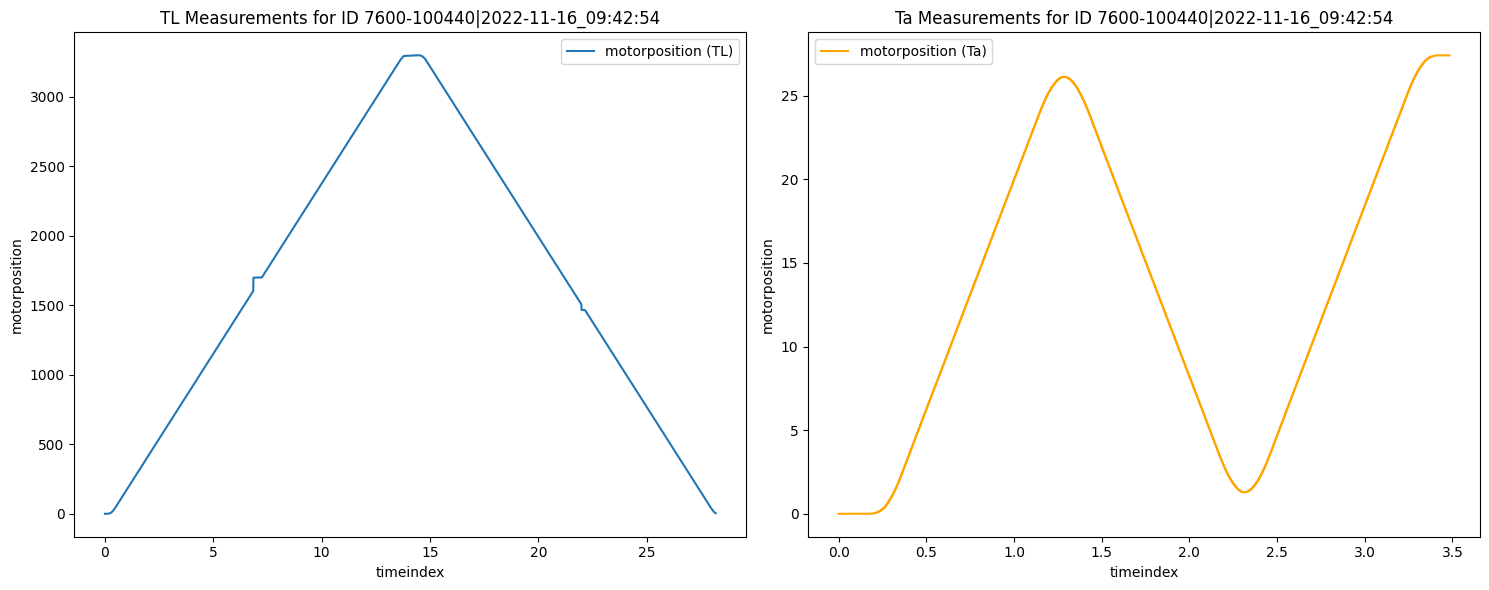

In [8]:
id = '7600-100440|2022-11-16_09:42:54'
plotseries(id,'motorposition',df)

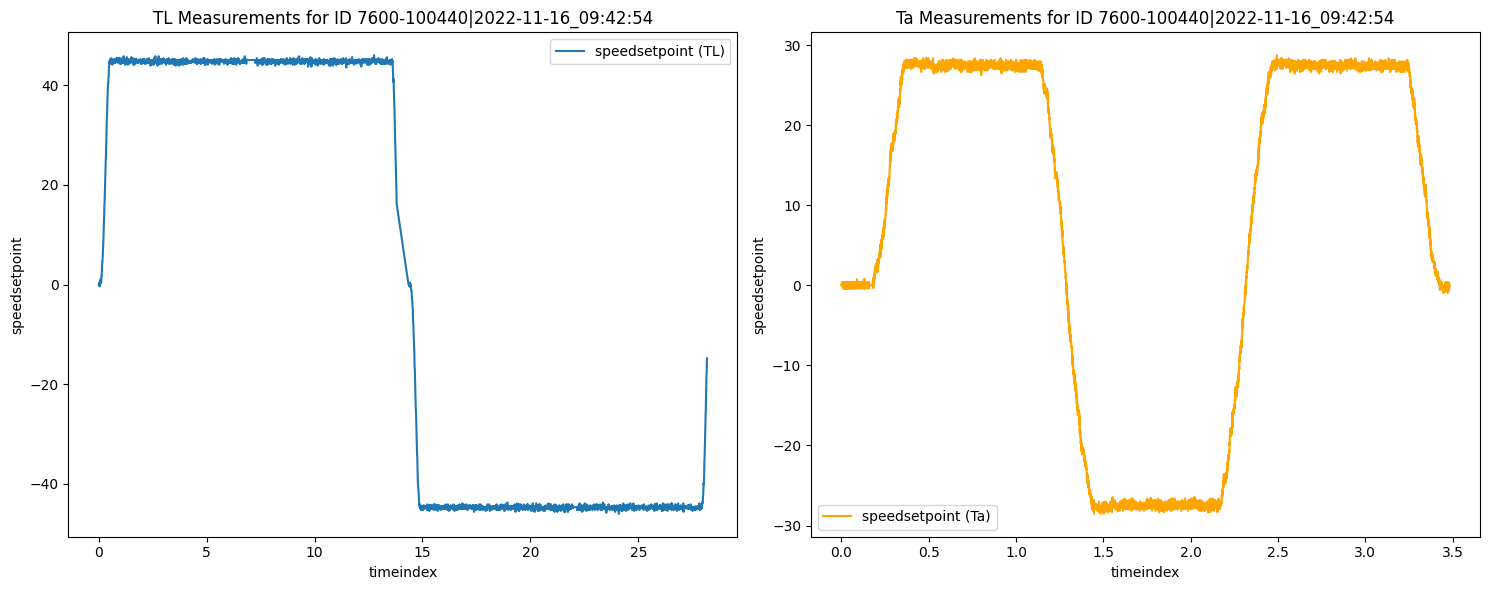

In [9]:
plotseries(id,'speedsetpoint',df)

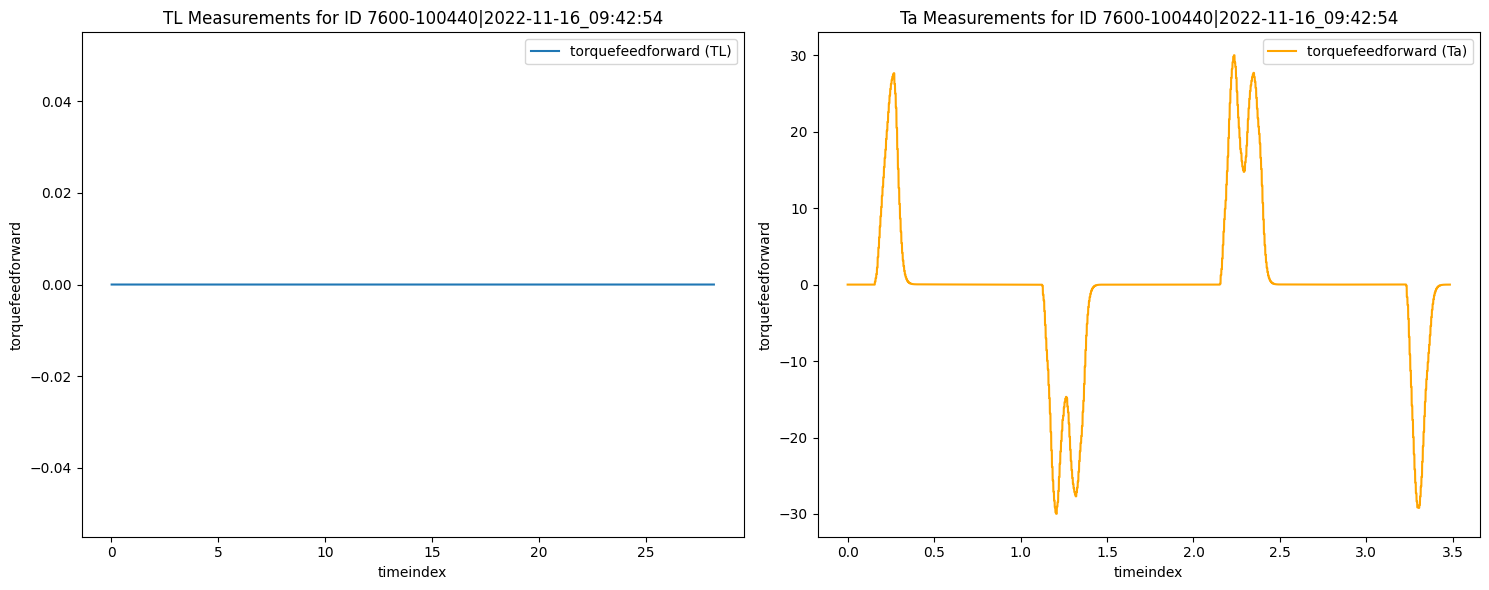

In [10]:
plotseries(id,'torquefeedforward',df)

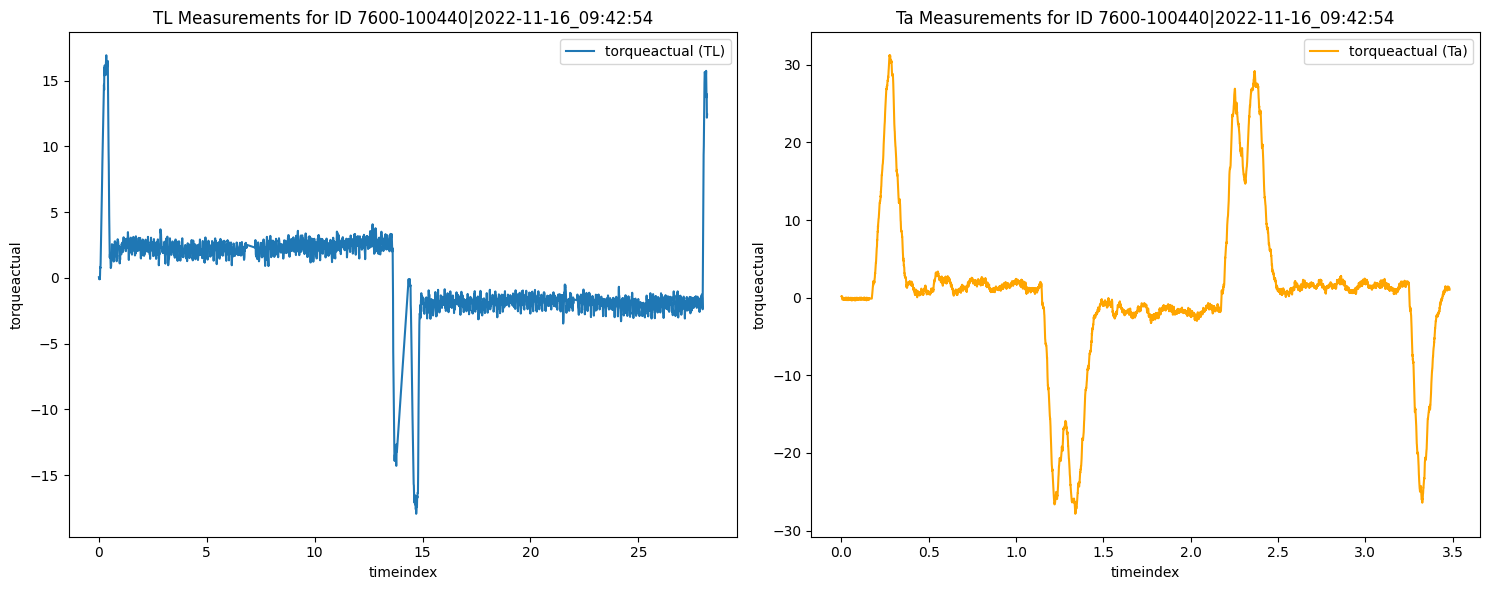

In [11]:
plotseries(id,'torqueactual',df)

## Preprocessing

1. take only the TL measurement
2. select columns of interest
3. standardize the data
4. decompose the torque signal

In [93]:
from sklearn.preprocessing import StandardScaler
from scipy.fft import rfft, rfftfreq, irfft
import numpy as np
import matplotlib.pyplot as plt
from data.spectrum import SpectrumDecomposition

tl_df = df[(df['type'] == 'TL')]
data = tl_df[['id', 'motorposition', 'speedsetpoint', 'torquefeedforward', 'torqueactual', 'timeindex']]
data.reset_index()
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[['torqueactual']])
data[['torqueactual']] = scaled_data


decomposer = SpectrumDecomposition(col_name="torqueactual", n_freq=25)
data_decomposed = decomposer.transform(data)


C:\Users\crist\AppData\Local\Temp\ipykernel_14248\3794847750.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[['torqueactual']] = scaled_data


# Local Outlier Finder

In [136]:
from sklearn.neighbors import LocalOutlierFactor

def local_outlier_factor(data):
    if 'timeindex' in data.columns:
        train = data.drop(['id', 'timeindex'], axis=1)
    else:
        train = data.drop(['id'], axis=1)
        
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
    outlier_scores = -lof.fit_predict(train)  # Negative scores indicate outliers

    # Convert scores to positive for better histogram representation
    outlier_scores = -lof.negative_outlier_factor_
    
    # Plotting the outlier scores in a histogram
    plt.figure(figsize=(10, 6))
    plt.hist(outlier_scores, bins=100, color='blue', edgecolor='black')
    # plt.xlim(left=None, right=2000000)  # Cutoff after 2 on the x-axis
    plt.title('LOF Outlier Scores')
    plt.xlabel('Negative Outlier Factor (Scores)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    data['outlier_scores'] = outlier_scores
    return data

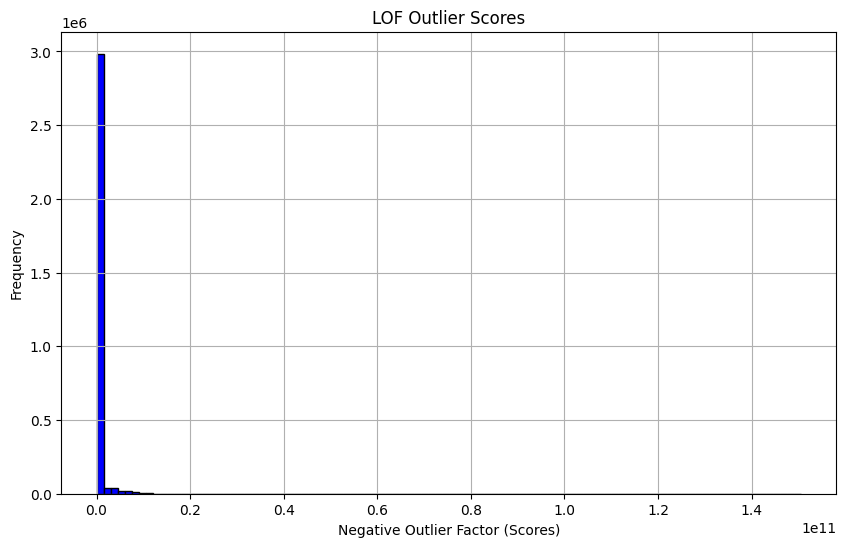

C:\Users\crist\AppData\Local\Temp\ipykernel_14248\105138294.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['outlier_scores'] = outlier_scores


In [124]:
lof_results = local_outlier_factor(data)

In [125]:
outliers = lof_results[lof_results['outlier_scores'] > 1]
print(len(outliers))
outliers.nunique()

576257


id                     178
motorposition        53027
speedsetpoint          477
torquefeedforward        1
torqueactual         77418
timeindex             7261
outlier_scores       82233
dtype: int64

In [97]:
data_decomposed.columns

Index(['id', 'timeindex', 'torqueactual', 'torqueactual_187200.0_194950.0',
       'torqueactual_179400.0_187150.0', 'torqueactual_171600.0_179350.0',
       'torqueactual_163800.0_171550.0', 'torqueactual_156000.0_163750.0',
       'torqueactual_148200.0_155950.0', 'torqueactual_140400.0_148150.0',
       'torqueactual_132600.0_140350.0', 'torqueactual_124800.0_132550.0',
       'torqueactual_117000.0_124750.0', 'torqueactual_109200.0_116950.0',
       'torqueactual_101400.0_109150.0', 'torqueactual_93600.0_101350.0',
       'torqueactual_85800.0_93550.0', 'torqueactual_78000.0_85750.0',
       'torqueactual_70200.0_77950.0', 'torqueactual_62400.0_70150.0',
       'torqueactual_54600.0_62350.0', 'torqueactual_46800.0_54550.0',
       'torqueactual_39000.0_46750.0', 'torqueactual_31200.0_38950.0',
       'torqueactual_23400.0_31150.0', 'torqueactual_15600.0_23350.0',
       'torqueactual_7800.0_15550.0', 'torqueactual_0.0_7750.0'],
      dtype='object')

In [100]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)  # Adjust the number of components as needed

# Fit PCA to the data and transform the DataFrame
pca_result = pca.fit_transform(data_decomposed.drop(['id','torqueactual'], axis=1))

# Create a new DataFrame from the transformed data
pca_df = pd.DataFrame(data=pca_result, columns=['PC'+str(i) for i in range(1,6)])
pca_df.reset_index(drop=True)
pca_df

,PC1,PC2,PC3,PC4,PC5
0,-30.240562,-1.202291,-0.361804,0.089006,-0.045619
1,-30.225952,-1.176679,-0.696084,-0.083918,-0.147426
2,-30.215420,-1.154335,-0.996659,-0.236626,-0.179344
3,-30.205993,-1.136314,-1.254226,-0.341552,-0.127236
4,-30.196695,-1.123539,-1.461510,-0.381030,-0.015664
...,...,...,...,...,...
3109767,42.768903,-3.876689,0.600771,0.364258,0.008639
3109768,42.779229,-3.827870,0.322058,0.467583,0.155622
3109769,42.789868,-3.768049,0.035908,0.482913,0.227688
3109770,42.800799,-3.698054,-0.247493,0.409007,0.192817


In [103]:

pca_df = pca_df.reset_index(drop=True)
pca_df = pd.concat([data_decomposed['id'].reset_index(drop=True), pca_df], axis=1)
pca_df

,id,PC1,PC2,PC3,PC4,PC5
0,7600-100440|2022-11-16_09:42:54,-30.240562,-1.202291,-0.361804,0.089006,-0.045619
1,7600-100440|2022-11-16_09:42:54,-30.225952,-1.176679,-0.696084,-0.083918,-0.147426
2,7600-100440|2022-11-16_09:42:54,-30.215420,-1.154335,-0.996659,-0.236626,-0.179344
3,7600-100440|2022-11-16_09:42:54,-30.205993,-1.136314,-1.254226,-0.341552,-0.127236
4,7600-100440|2022-11-16_09:42:54,-30.196695,-1.123539,-1.461510,-0.381030,-0.015664
...,...,...,...,...,...,...
3109767,7600-100498|2022-09-25_11:04:17,42.768903,-3.876689,0.600771,0.364258,0.008639
3109768,7600-100498|2022-09-25_11:04:17,42.779229,-3.827870,0.322058,0.467583,0.155622
3109769,7600-100498|2022-09-25_11:04:17,42.789868,-3.768049,0.035908,0.482913,0.227688
3109770,7600-100498|2022-09-25_11:04:17,42.800799,-3.698054,-0.247493,0.409007,0.192817


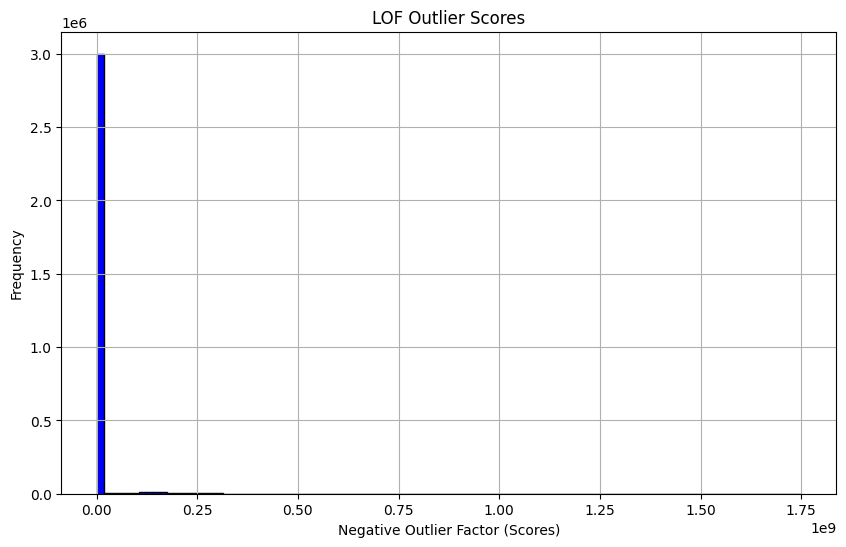

In [106]:
import os
os.environ['LOKY_MAX_CPU_COUNT'] = '4' 
lof_results = local_outlier_factor(pca_df)

In [107]:
outliers = lof_results[lof_results['outlier_scores'] > 1]
print(len(outliers))
outliers.nunique()

596413


id                  178
PC1               85848
PC2               85849
PC3               85850
PC4               85853
PC5               85857
outlier_scores    85659
dtype: int64

## Figuring out time indices - Interpolation

In [108]:
def normalize_time_index(df):
    df['timeindex'] = df['timeindex'].round(2)*100
    df = df.groupby(['timeindex','id']).agg('max').reset_index()
    max_inds = [max(df[df['id'] == id]['timeindex'].values) for id in df['id'].unique()]
    max_time_index = max(max_inds)
    min_inds = [min(df[df['id'] == id]['timeindex'].values) for id in df['id'].unique()]
    min_time_index = min(min_inds)
    
    print(max_time_index, min_time_index)
    
    return df

normalized = normalize_time_index(data)
normalized

C:\Users\crist\AppData\Local\Temp\ipykernel_14248\2935332266.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timeindex'] = df['timeindex'].round(2)*100


7313.0 1.0


,timeindex,id,motorposition,speedsetpoint,torquefeedforward,torqueactual,outlier_scores
0,1.0,7600-100440|2022-01-01_04:56:40,0.00,-0.0000,0.0,-0.014695,2.933225
1,1.0,7600-100440|2022-01-02_04:55:08,0.00,-0.0000,0.0,-0.014695,2.933225
2,1.0,7600-100440|2022-01-03_06:36:32,0.00,-0.0000,0.0,-0.014695,2.933225
3,1.0,7600-100440|2022-01-04_04:58:30,0.00,-0.0000,0.0,-0.014695,2.933225
4,1.0,7600-100440|2022-01-05_04:59:38,0.00,-0.0000,0.0,-0.014695,2.933225
...,...,...,...,...,...,...,...
2820683,7313.0,7600-100498|2022-12-27_08:10:14,4.58,-15.0278,0.0,3.614445,1.000000
2820684,7313.0,7600-100498|2022-12-28_09:31:34,4.58,-15.0278,0.0,3.614445,1.000000
2820685,7313.0,7600-100498|2022-12-29_09:42:28,4.58,-15.0278,0.0,3.614445,1.000000
2820686,7313.0,7600-100498|2022-12-30_08:16:58,4.58,-15.0278,0.0,3.614445,1.000000


In [134]:
robot = normalized[normalized['id'].str.startswith("7600-100440")]
robot['timeindex'] = robot['timeindex'].astype(int)
max_time = robot['timeindex'].max()
min_time = robot['timeindex'].min()


C:\Users\crist\AppData\Local\Temp\ipykernel_14248\2287290185.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  robot['timeindex'] = robot['timeindex'].astype(int)


In [135]:
full_range_df = pd.DataFrame({'timeindex': range(min_time, max_time+1)})

# Merge with the original DataFrame
merged_df = full_range_df.merge(robot, on='timeindex', how='left')

# Interpolate the missing values in other columns
interpolated_df = merged_df.interpolate(method='linear')

interpolated_df

C:\Users\crist\AppData\Local\Temp\ipykernel_14248\1532436636.py:7: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  interpolated_df = merged_df.interpolate(method='linear')


,timeindex,id,motorposition,speedsetpoint,torquefeedforward,torqueactual,outlier_scores
0,1,7600-100440|2022-01-01_04:56:40,0.00,-0.0000,0.0,-0.014695,2.933225
1,1,7600-100440|2022-01-02_04:55:08,0.00,-0.0000,0.0,-0.014695,2.933225
2,1,7600-100440|2022-01-03_06:36:32,0.00,-0.0000,0.0,-0.014695,2.933225
3,1,7600-100440|2022-01-04_04:58:30,0.00,-0.0000,0.0,-0.014695,2.933225
4,1,7600-100440|2022-01-05_04:59:38,0.00,-0.0000,0.0,-0.014695,2.933225
...,...,...,...,...,...,...,...
816826,2820,7600-100440|2022-11-19_08:14:32,4.83,-15.2181,0.0,3.459558,1.456185
816827,2820,7600-100440|2022-11-20_08:14:08,4.83,-15.2181,0.0,3.459558,1.456185
816828,2820,7600-100440|2022-11-21_08:13:06,4.83,-15.2181,0.0,3.459558,1.456185
816829,2820,7600-100440|2022-11-22_09:42:30,4.83,-15.2181,0.0,3.459558,1.456185


## LOF with Interpolation

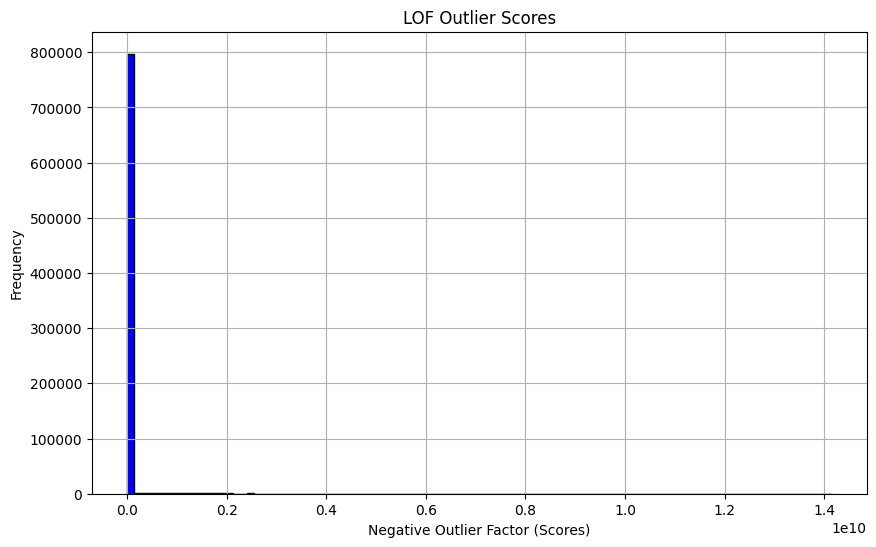

In [137]:
lof_results = local_outlier_factor(interpolated_df)

In [156]:
outliers = lof_results[lof_results['outlier_scores'] > 5]
print(len(outliers))
outliers.nunique()

27490


timeindex            2012
id                    123
motorposition        2955
speedsetpoint         153
torquefeedforward       1
torqueactual         3895
outlier_scores       3798
dtype: int64

In [140]:
len(lof_results)

816831

## Isolation Forest

In [168]:
from sklearn.ensemble import IsolationForest

# Train Isolation Forest on the signals
iso_forest = IsolationForest(contamination=0.05)
iso_forest.fit(data_decomposed.drop(['id'],axis=1))

IsolationForest(contamination=0.05)

In [169]:
data_decomposed['outliers'] = iso_forest.predict(data_decomposed.drop(['id'],axis=1))

In [170]:
data_decomposed[data_decomposed['outliers']==-1]['id'].nunique()

588

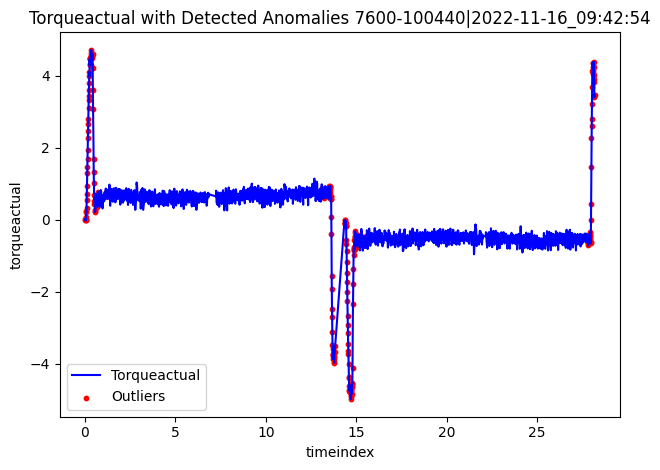

In [171]:
# Highlighting detected anomalies in torqueactual

example = data_decomposed[data_decomposed['id']==id]

plt.plot(example['timeindex'], example['torqueactual'], label='Torqueactual', color='blue')
plt.scatter(example.loc[example['outliers'] == -1, 'timeindex'],
            example.loc[example['outliers'] == -1, 'torqueactual'],
            color='red', s=10, label='Outliers')
plt.title('Torqueactual with Detected Anomalies'+' '+id)
plt.xlabel('timeindex')
plt.ylabel('torqueactual')
plt.legend()

plt.tight_layout()
plt.show()

,id,timeindex,torqueactual,torqueactual_187200.0_194950.0,torqueactual_179400.0_187150.0,torqueactual_171600.0_179350.0,torqueactual_163800.0_171550.0,torqueactual_156000.0_163750.0,torqueactual_148200.0_155950.0,torqueactual_140400.0_148150.0,...,torqueactual_70200.0_77950.0,torqueactual_62400.0_70150.0,torqueactual_54600.0_62350.0,torqueactual_46800.0_54550.0,torqueactual_39000.0_46750.0,torqueactual_31200.0_38950.0,torqueactual_23400.0_31150.0,torqueactual_15600.0_23350.0,torqueactual_7800.0_15550.0,torqueactual_0.0_7750.0
0,7600-100440|2022-11-16_09:42:54,0.009,0.017380,-0.061753,-0.101701,-0.066128,-0.087675,-0.061855,-0.091178,-0.038421,...,-0.066998,-0.057205,-0.002049,-0.137280,-0.050269,-0.184383,0.088985,-0.207196,-0.361678,2.086562
1,7600-100440|2022-11-16_09:42:54,0.023,-0.023484,0.062650,0.092077,0.066244,0.063669,0.036524,0.043691,-0.007917,...,-0.098545,-0.176903,-0.069650,-0.189981,-0.153214,-0.269973,-0.083929,-0.258177,-0.696121,2.062635
2,7600-100440|2022-11-16_09:42:54,0.033,-0.021959,-0.063302,-0.078986,-0.059638,-0.027366,-0.000657,0.023416,0.048914,...,-0.005729,-0.110689,-0.078165,-0.127227,-0.185782,-0.274598,-0.236622,-0.286694,-0.996830,2.041813
3,7600-100440|2022-11-16_09:42:54,0.042,0.014936,0.063711,0.062973,0.047142,-0.014097,-0.034840,-0.079386,-0.059278,...,0.094323,0.068691,-0.017548,0.012427,-0.133717,-0.199112,-0.341528,-0.291081,-1.254496,2.025030
4,7600-100440|2022-11-16_09:42:54,0.051,-0.024036,-0.063881,-0.044705,-0.030201,0.052585,0.059346,0.098784,0.033043,...,0.075251,0.172376,0.061129,0.143697,-0.021695,-0.068077,-0.380986,-0.271861,-1.461842,2.013159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7770,7600-100498|2022-09-25_11:04:17,73.065,3.443878,0.045483,0.050767,0.029472,-0.078214,-0.057117,-0.084730,-0.068109,...,-0.153651,-0.118729,-0.230906,-0.037810,0.013362,0.117739,0.366815,0.170378,0.633463,2.623043
7771,7600-100498|2022-09-25_11:04:17,73.074,3.880100,-0.048384,-0.060859,-0.046505,0.045799,0.049393,0.076136,0.063574,...,-0.104234,-0.061553,-0.104627,0.092274,0.160138,0.211767,0.470150,0.160158,0.354490,2.575463
7772,7600-100498|2022-09-25_11:04:17,73.083,3.627647,0.051044,0.068591,0.058910,-0.003941,-0.024851,-0.033238,-0.019503,...,0.078320,0.054908,0.110296,0.165536,0.231586,0.241659,0.485482,0.129951,0.068003,2.516992
7773,7600-100498|2022-09-25_11:04:17,73.092,3.798521,-0.053438,-0.073636,-0.065196,-0.039183,-0.008964,-0.023999,-0.037011,...,0.162315,0.117635,0.234361,0.132900,0.195602,0.195918,0.411566,0.081197,-0.215809,2.448405


## Trying to remove the spikes

In [184]:
def remove_spikes(df, window_ratio=0.02):
    result_df = pd.DataFrame(columns=df.columns)
    for id in df['id'].unique():
        process = df[df['id']==id]
        window_size = int(len(process) * window_ratio)

        # Define indices for the three sections: beginning, middle, and end
        start_idx = 0
        mid_start_idx = len(process) // 2 - window_size
        mid_end_idx = mid_start_idx + window_size * 2
        end_idx = len(process) - window_size
    
        df_cleaned = pd.concat([
            process.iloc[window_size:mid_start_idx],
            process.iloc[mid_end_idx:end_idx]
        ])
        result_df = pd.concat([result_df,df_cleaned.reset_index(drop=True)], ignore_index=True)

    return result_df



In [185]:
no_spike_df = remove_spikes(data.drop(['outlier_scores'],axis=1))

C:\Users\crist\AppData\Local\Temp\ipykernel_14248\1569464281.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df,df_cleaned.reset_index(drop=True)], ignore_index=True)


In [186]:
decomposer = SpectrumDecomposition(col_name="torqueactual", n_freq=25)
data_decomposed = decomposer.transform(no_spike_df)

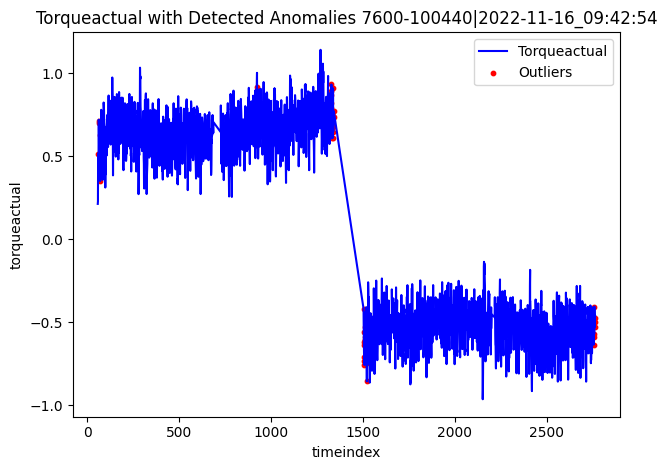

In [187]:
from sklearn.ensemble import IsolationForest

# Train Isolation Forest on the signals
iso_forest = IsolationForest(contamination=0.05)
iso_forest.fit(data_decomposed.drop(['id'], axis=1))
data_decomposed['outliers'] = iso_forest.predict(data_decomposed.drop(['id'], axis=1))

# Highlighting detected anomalies in torqueactual

example = data_decomposed[data_decomposed['id'] == id]

plt.plot(example['timeindex'], example['torqueactual'], label='Torqueactual', color='blue')
plt.scatter(example.loc[example['outliers'] == -1, 'timeindex'],
            example.loc[example['outliers'] == -1, 'torqueactual'],
            color='red', s=10, label='Outliers')
plt.title('Torqueactual with Detected Anomalies' + ' ' + id)
plt.xlabel('timeindex')
plt.ylabel('torqueactual')
plt.legend()

plt.tight_layout()
plt.show()

In [188]:
data_decomposed[data_decomposed['outliers'] == -1]['id'].nunique()

588

In [189]:
len(data_decomposed[data_decomposed['outliers'] == -1])

143055

In [190]:
len(data_decomposed)

2861948